Using device: cuda
Mounted at /content/drive
✅ Data loaded!
Train: (77366, 45), Val: (9660, 45), Test: (9670, 45)
✅ Feature engineering done! Selected features: 40

🤖 Training models with optimal hyperparameters...

[1/4] Linear Regression (Poly + Ridge)...
   R²: 0.5549
[2/4] Random Forest...
   R²: 0.9742
[3/4] XGBoost...
   R²: 0.9773
[4/4] FT Transformer...
   Epoch 20/100 | Val Loss: 80.7085
   Epoch 40/100 | Val Loss: 18.7529
   Epoch 60/100 | Val Loss: 10.5206
   Epoch 80/100 | Val Loss: 6.1852
   Epoch 100/100 | Val Loss: 5.2282
   R²: 0.9774

✅ All models trained!

📊 Creating visualizations...


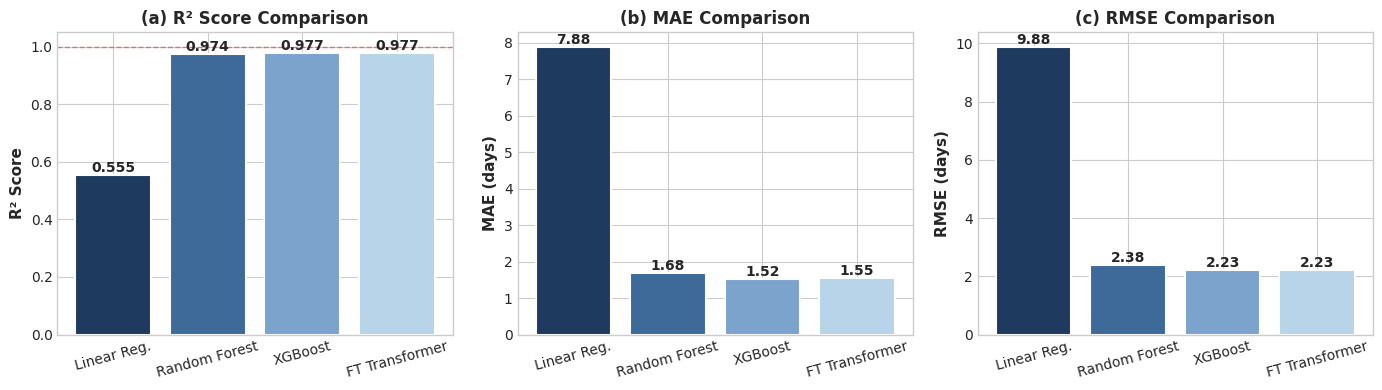

✅ fig1_model_comparison.png saved


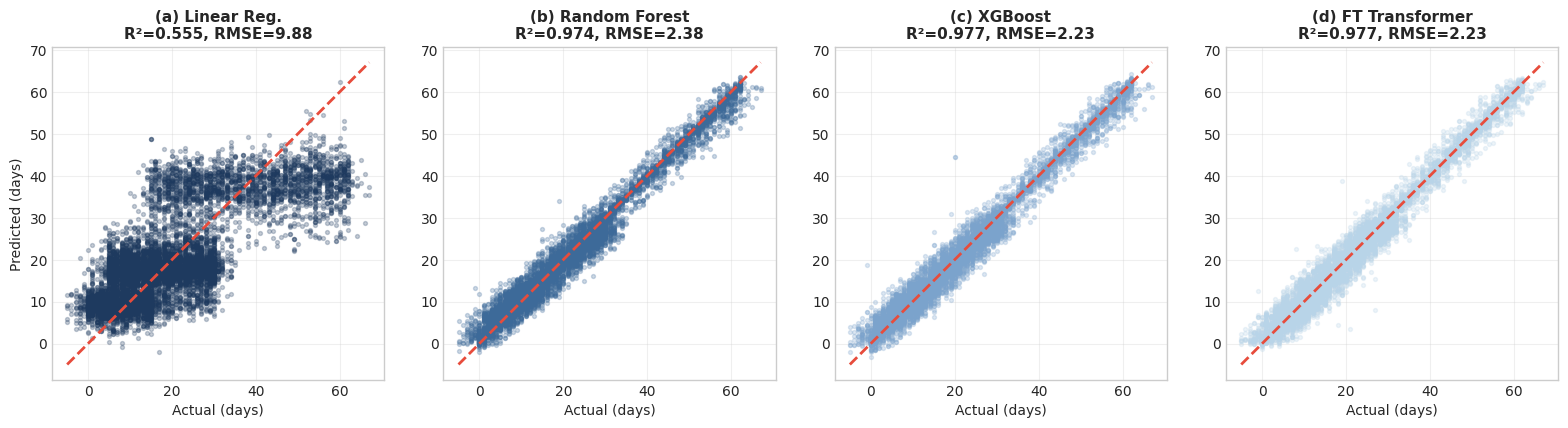

✅ fig2_actual_vs_predicted.png saved


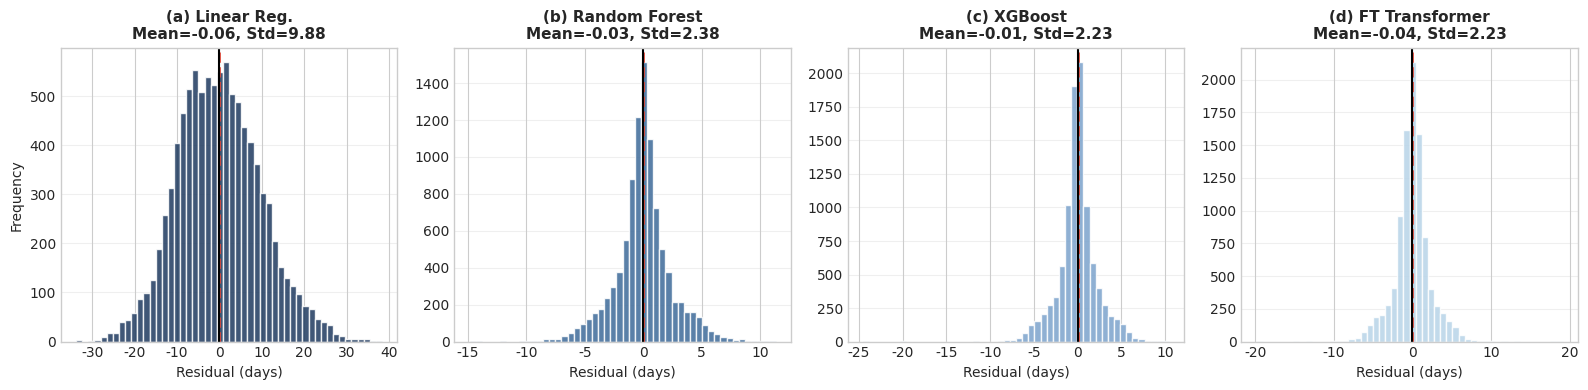

✅ fig3_residual_distribution.png saved


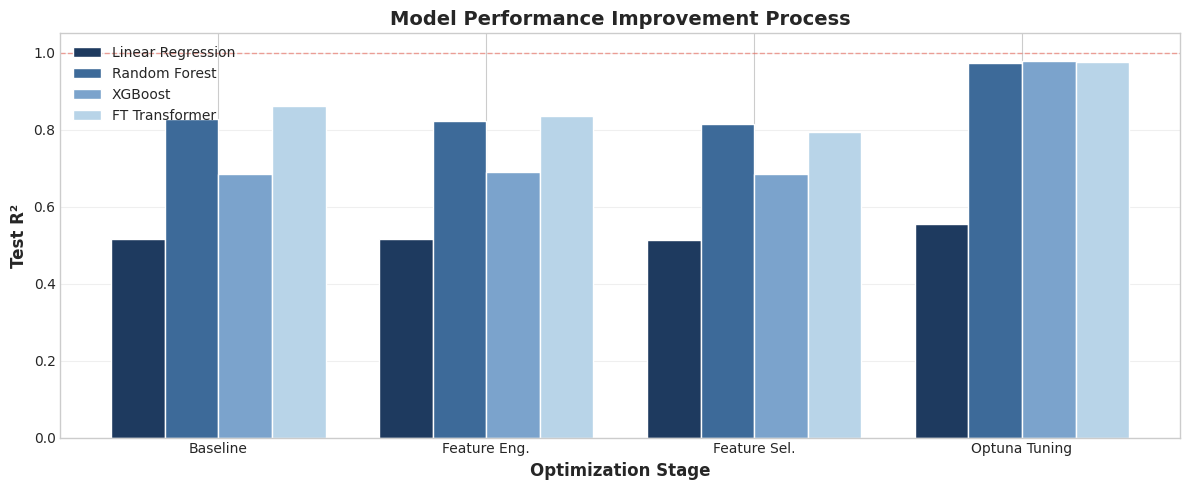

✅ fig4_improvement_process.png saved


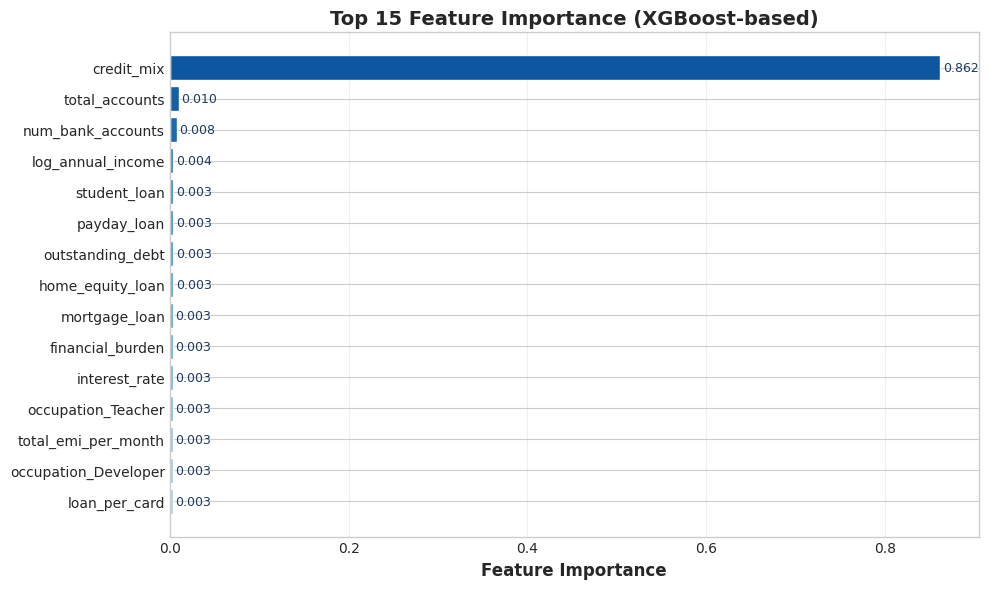

✅ fig5_feature_importance.png saved


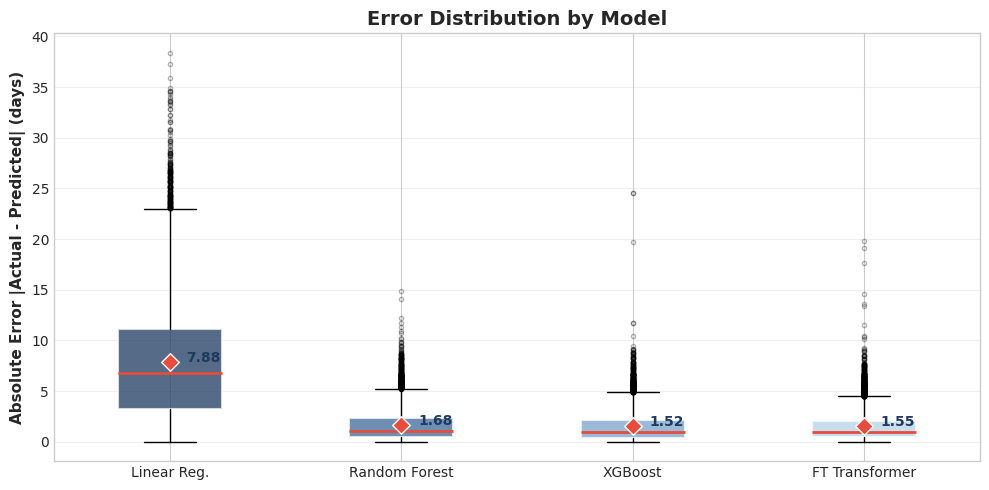

✅ fig6_error_boxplot.png saved


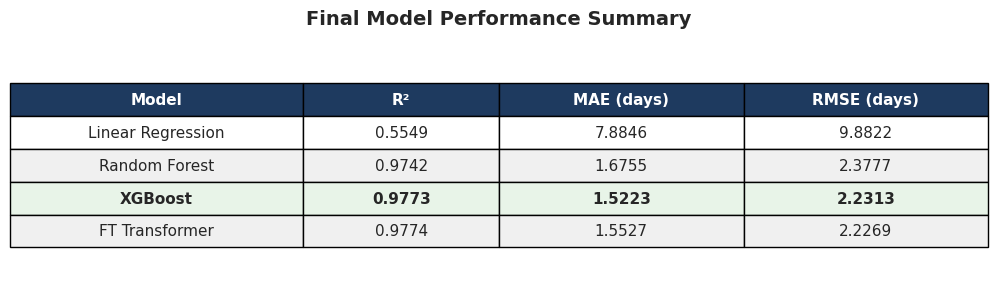

✅ fig7_summary_table.png saved

📊 Final Results Summary
                       R²     MAE    RMSE
Linear Regression  0.5549  7.8846  9.8822
Random Forest      0.9742  1.6755  2.3777
XGBoost            0.9773  1.5223  2.2313
FT Transformer     0.9774  1.5527  2.2269

🏆 Best Model: XGBoost (Test R² = 0.9773)

✅ All visualizations saved!
   - fig1_model_comparison.png      (Model metrics comparison)
   - fig2_actual_vs_predicted.png   (Scatter plots)
   - fig3_residual_distribution.png (Residual histograms)
   - fig4_improvement_process.png   (Stage-wise improvement)
   - fig5_feature_importance.png    (Top 15 features)
   - fig6_error_boxplot.png         (Error distribution)
   - fig7_summary_table.png         (Results table)


In [ ]:
# ============================================
# 📊 Task 2: Regression 결과 시각화 (개선 버전)
# ============================================
# Google Colab에서 실행하세요!

# ============================================
# 📦 라이브러리 임포트
# ============================================
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# ============================================
# 🎨 스타일 설정 (통일감 있는 블루 계열)
# ============================================
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# 블루 그라데이션 컬러 팔레트
COLORS = {
    'primary': '#1e3a5f',      # 진한 네이비
    'secondary': '#3d6a99',    # 중간 블루
    'tertiary': '#7ba3cc',     # 연한 블루
    'quaternary': '#b8d4e8',   # 아주 연한 블루
    'accent': '#e74c3c',       # 강조색 (빨강)
    'light_gray': '#f0f0f0'
}


# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================
# 📂 데이터 로드
# ============================================
from google.colab import drive
drive.mount('/content/drive')

LOAD_PATH = '/content/drive/MyDrive/preprocessed_data.pkl'
with open(LOAD_PATH, 'rb') as f:
    data = pickle.load(f)

X_train_reg = data['X_train_reg']
X_val_reg = data['X_val_reg']
X_test_reg = data['X_test_reg']
y_train_reg = data['y_train_reg']
y_val_reg = data['y_val_reg']
y_test_reg = data['y_test_reg']

print(f"✅ Data loaded!")
print(f"Train: {X_train_reg.shape}, Val: {X_val_reg.shape}, Test: {X_test_reg.shape}")

# ============================================
# 🔧 전처리 및 피처 엔지니어링
# ============================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reg)
X_val_scaled = scaler.transform(X_val_reg)
X_test_scaled = scaler.transform(X_test_reg)

feature_names = X_train_reg.columns.tolist()
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_val_df = pd.DataFrame(X_val_scaled, columns=feature_names)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)

def create_features(df, feature_names):
    df_new = df.copy()
    cols = feature_names

    if 'outstanding_debt' in cols and 'monthly_inhand_salary' in cols:
        idx_debt, idx_salary = cols.index('outstanding_debt'), cols.index('monthly_inhand_salary')
        df_new['debt_to_income'] = df.iloc[:, idx_debt] / (df.iloc[:, idx_salary] + 1e-8)
    if 'total_emi_per_month' in cols and 'monthly_inhand_salary' in cols:
        idx_emi, idx_salary = cols.index('total_emi_per_month'), cols.index('monthly_inhand_salary')
        df_new['emi_to_income'] = df.iloc[:, idx_emi] / (df.iloc[:, idx_salary] + 1e-8)
    if 'amount_invested_monthly' in cols and 'monthly_inhand_salary' in cols:
        idx_invest, idx_salary = cols.index('amount_invested_monthly'), cols.index('monthly_inhand_salary')
        df_new['invest_to_income'] = df.iloc[:, idx_invest] / (df.iloc[:, idx_salary] + 1e-8)
    if 'num_of_loan' in cols and 'num_credit_card' in cols:
        idx_loan, idx_card = cols.index('num_of_loan'), cols.index('num_credit_card')
        df_new['loan_per_card'] = df.iloc[:, idx_loan] / (df.iloc[:, idx_card] + 1e-8)
    if 'num_of_delayed_payment' in cols and 'interest_rate' in cols:
        idx_delay, idx_rate = cols.index('num_of_delayed_payment'), cols.index('interest_rate')
        df_new['delay_interest_interaction'] = df.iloc[:, idx_delay] * df.iloc[:, idx_rate]
    if 'credit_utilization_ratio' in cols and 'outstanding_debt' in cols:
        idx_util, idx_debt = cols.index('credit_utilization_ratio'), cols.index('outstanding_debt')
        df_new['util_debt_interaction'] = df.iloc[:, idx_util] * df.iloc[:, idx_debt]
    if 'age' in cols and 'credit_history_age' in cols:
        idx_age, idx_history = cols.index('age'), cols.index('credit_history_age')
        df_new['age_history_interaction'] = df.iloc[:, idx_age] * df.iloc[:, idx_history]
    if 'num_bank_accounts' in cols and 'num_credit_card' in cols:
        idx_bank, idx_card = cols.index('num_bank_accounts'), cols.index('num_credit_card')
        df_new['total_accounts'] = df.iloc[:, idx_bank] + df.iloc[:, idx_card]
    if 'outstanding_debt' in cols and 'total_emi_per_month' in cols and 'num_of_loan' in cols:
        idx_debt, idx_emi, idx_loan = cols.index('outstanding_debt'), cols.index('total_emi_per_month'), cols.index('num_of_loan')
        df_new['financial_burden'] = df.iloc[:, idx_debt] + df.iloc[:, idx_emi] * 12 + df.iloc[:, idx_loan] * 100
    if 'num_of_delayed_payment' in cols:
        idx_delay = cols.index('num_of_delayed_payment')
        df_new['delayed_payment_sq'] = df.iloc[:, idx_delay] ** 2
    if 'credit_utilization_ratio' in cols:
        idx_util = cols.index('credit_utilization_ratio')
        df_new['credit_util_sq'] = df.iloc[:, idx_util] ** 2
    if 'annual_income' in cols:
        idx_income = cols.index('annual_income')
        df_new['log_annual_income'] = np.log1p(np.abs(df.iloc[:, idx_income]))
    if 'outstanding_debt' in cols:
        idx_debt = cols.index('outstanding_debt')
        df_new['log_outstanding_debt'] = np.log1p(np.abs(df.iloc[:, idx_debt]))
    return df_new

X_train_fe = create_features(X_train_df, feature_names)
X_val_fe = create_features(X_val_df, feature_names)
X_test_fe = create_features(X_test_df, feature_names)

# Feature Selection
temp_xgb = XGBRegressor(n_estimators=100, max_depth=6, random_state=42, verbosity=0)
temp_xgb.fit(X_train_fe, y_train_reg)

importance_df = pd.DataFrame({
    'feature': X_train_fe.columns,
    'importance': temp_xgb.feature_importances_
}).sort_values('importance', ascending=False)

corr_matrix = X_train_fe.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
features_to_drop = set()
for col in upper_tri.columns:
    correlated = upper_tri.index[upper_tri[col] > 0.95].tolist()
    for corr_col in correlated:
        imp1 = importance_df[importance_df['feature'] == col]['importance'].values
        imp2 = importance_df[importance_df['feature'] == corr_col]['importance'].values
        imp1, imp2 = (imp1[0] if len(imp1) > 0 else 0), (imp2[0] if len(imp2) > 0 else 0)
        features_to_drop.add(col if imp1 < imp2 else corr_col)

remaining_features = [f for f in importance_df['feature'] if f not in features_to_drop]
selected_features = remaining_features[:40]

X_train_selected = X_train_fe[selected_features]
X_val_selected = X_val_fe[selected_features]
X_test_selected = X_test_fe[selected_features]

print(f"✅ Feature engineering done! Selected features: {len(selected_features)}")

# ============================================
# 🤖 모델 학습 (최적 하이퍼파라미터 사용)
# ============================================
print("\n" + "="*60)
print("🤖 Training models with optimal hyperparameters...")
print("="*60)

predictions = {}
results = {}

# --- 1. Linear Regression (Poly + Ridge) ---
print("\n[1/4] Linear Regression (Poly + Ridge)...")
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_train_poly = poly.fit_transform(X_train_selected)
X_val_poly = poly.transform(X_val_selected)
X_test_poly = poly.transform(X_test_selected)

lr_model = Ridge(alpha=10.0, random_state=42)
lr_model.fit(X_train_poly, y_train_reg)
y_pred_lr = lr_model.predict(X_test_poly)

results['Linear Regression'] = {
    'R2': r2_score(y_test_reg, y_pred_lr),
    'MAE': mean_absolute_error(y_test_reg, y_pred_lr),
    'RMSE': np.sqrt(mean_squared_error(y_test_reg, y_pred_lr))
}
predictions['Linear Regression'] = y_pred_lr
print(f"   R²: {results['Linear Regression']['R2']:.4f}")

# --- 2. Random Forest ---
print("[2/4] Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=274, max_depth=30, min_samples_split=6,
    min_samples_leaf=1, max_features='sqrt', bootstrap=False,
    random_state=42, n_jobs=-1
)
rf_model.fit(X_train_selected, y_train_reg)
y_pred_rf = rf_model.predict(X_test_selected)

results['Random Forest'] = {
    'R2': r2_score(y_test_reg, y_pred_rf),
    'MAE': mean_absolute_error(y_test_reg, y_pred_rf),
    'RMSE': np.sqrt(mean_squared_error(y_test_reg, y_pred_rf))
}
predictions['Random Forest'] = y_pred_rf
print(f"   R²: {results['Random Forest']['R2']:.4f}")

# --- 3. XGBoost ---
print("[3/4] XGBoost...")
xgb_model = XGBRegressor(
    n_estimators=412, max_depth=14, learning_rate=0.0495,
    subsample=0.739, colsample_bytree=0.972, min_child_weight=3,
    reg_alpha=1.26e-05, reg_lambda=0.190, gamma=1.79e-08,
    random_state=42, verbosity=0, n_jobs=-1
)
xgb_model.fit(X_train_selected, y_train_reg)
y_pred_xgb = xgb_model.predict(X_test_selected)

results['XGBoost'] = {
    'R2': r2_score(y_test_reg, y_pred_xgb),
    'MAE': mean_absolute_error(y_test_reg, y_pred_xgb),
    'RMSE': np.sqrt(mean_squared_error(y_test_reg, y_pred_xgb))
}
predictions['XGBoost'] = y_pred_xgb
print(f"   R²: {results['XGBoost']['R2']:.4f}")

# --- 4. FT Transformer ---
print("[4/4] FT Transformer...")

class NumericalEmbedding(nn.Module):
    def __init__(self, n_features, d_model):
        super().__init__()
        self.linear = nn.Linear(n_features, d_model)
        self.norm = nn.LayerNorm(d_model)
    def forward(self, x):
        return self.norm(self.linear(x))

class FTTransformer(nn.Module):
    def __init__(self, n_num_features, d_model=128, n_heads=8, n_layers=4,
                 d_ffn=64, dropout=0.0005, d_out=1):
        super().__init__()
        self.num_embedding = NumericalEmbedding(n_num_features, d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=d_ffn,
            dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.head = nn.Sequential(
            nn.Linear(d_model, d_ffn), nn.ReLU(), nn.Dropout(dropout), nn.Linear(d_ffn, d_out)
        )
    def forward(self, x_num):
        batch_size = x_num.size(0)
        num_emb = self.num_embedding(x_num).unsqueeze(1)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, num_emb], dim=1)
        x = self.transformer(x)
        return self.head(x[:, 0, :])

X_train_t = torch.tensor(X_train_selected.values, dtype=torch.float32, device=device)
X_val_t = torch.tensor(X_val_selected.values, dtype=torch.float32, device=device)
X_test_t = torch.tensor(X_test_selected.values, dtype=torch.float32, device=device)
y_train_t = torch.tensor(y_train_reg.values, dtype=torch.float32, device=device).reshape(-1, 1)
y_val_t = torch.tensor(y_val_reg.values, dtype=torch.float32, device=device).reshape(-1, 1)

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

ft_model = FTTransformer(n_num_features=X_train_selected.shape[1]).to(device)
optimizer = torch.optim.AdamW(ft_model.parameters(), lr=0.00056, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
criterion = nn.MSELoss()

best_val_loss = float('inf')
patience_counter = 0
best_state = None

for epoch in range(100):
    ft_model.train()
    for x_batch, y_batch in train_loader:
        pred = ft_model(x_batch)
        loss = criterion(pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    ft_model.eval()
    with torch.no_grad():
        val_pred = ft_model(X_val_t)
        val_loss = criterion(val_pred, y_val_t).item()
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_state = {k: v.cpu().clone() for k, v in ft_model.state_dict().items()}
    else:
        patience_counter += 1

    if patience_counter >= 15:
        print(f"   Early stopping at epoch {epoch+1}")
        break

    if (epoch + 1) % 20 == 0:
        print(f"   Epoch {epoch+1}/100 | Val Loss: {val_loss:.4f}")

ft_model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
ft_model.eval()
with torch.no_grad():
    y_pred_ft = ft_model(X_test_t).cpu().numpy().flatten()

results['FT Transformer'] = {
    'R2': r2_score(y_test_reg, y_pred_ft),
    'MAE': mean_absolute_error(y_test_reg, y_pred_ft),
    'RMSE': np.sqrt(mean_squared_error(y_test_reg, y_pred_ft))
}
predictions['FT Transformer'] = y_pred_ft
print(f"   R²: {results['FT Transformer']['R2']:.4f}")

print("\n✅ All models trained!")




📊 Creating visualizations...


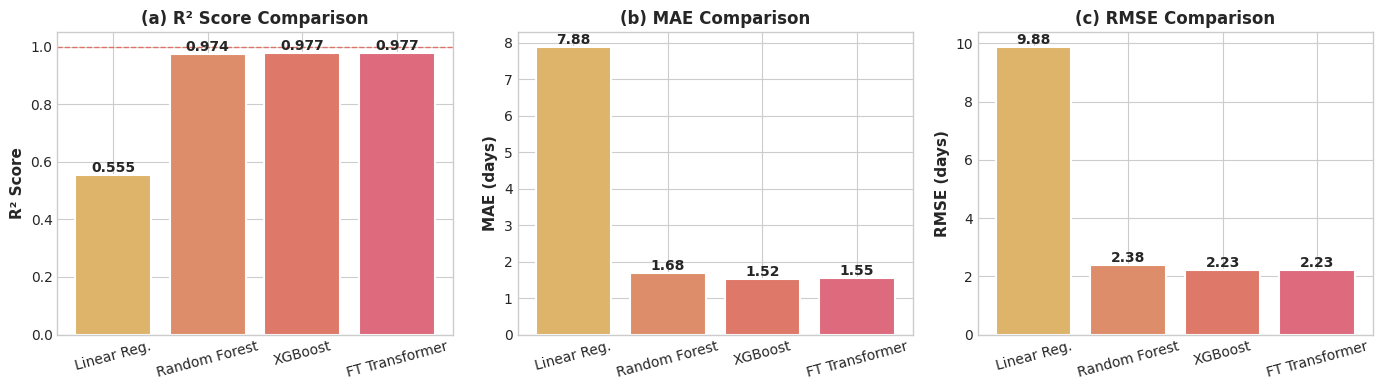

✅ fig1_model_comparison.png saved


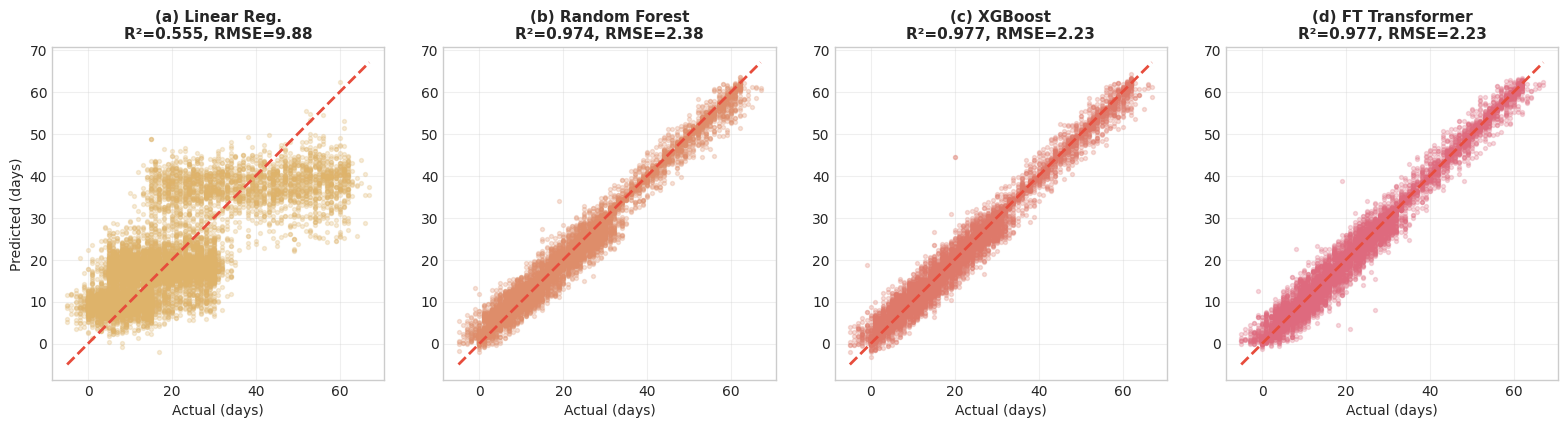

✅ fig2_actual_vs_predicted.png saved


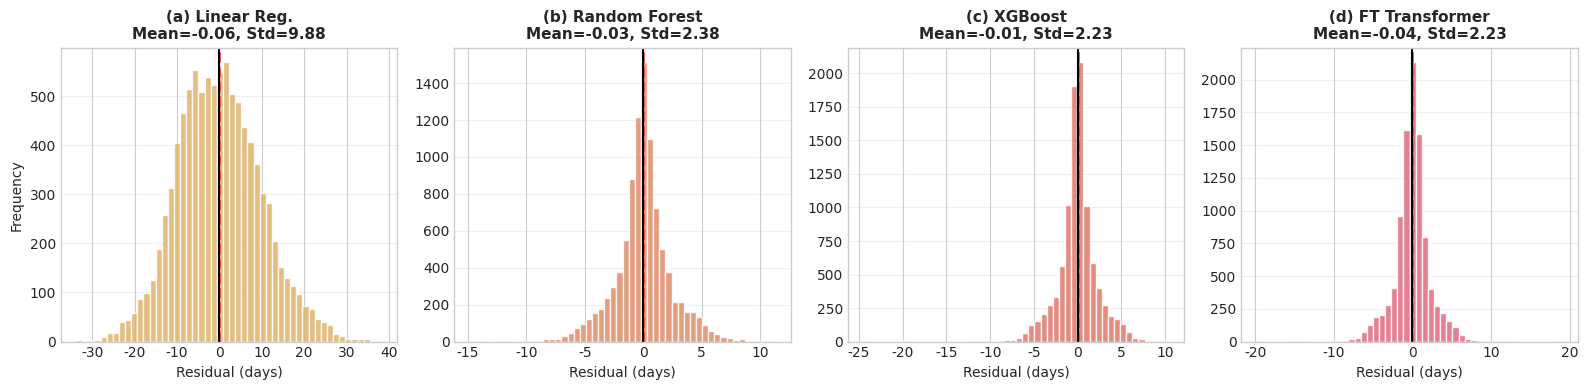

✅ fig3_residual_distribution.png saved


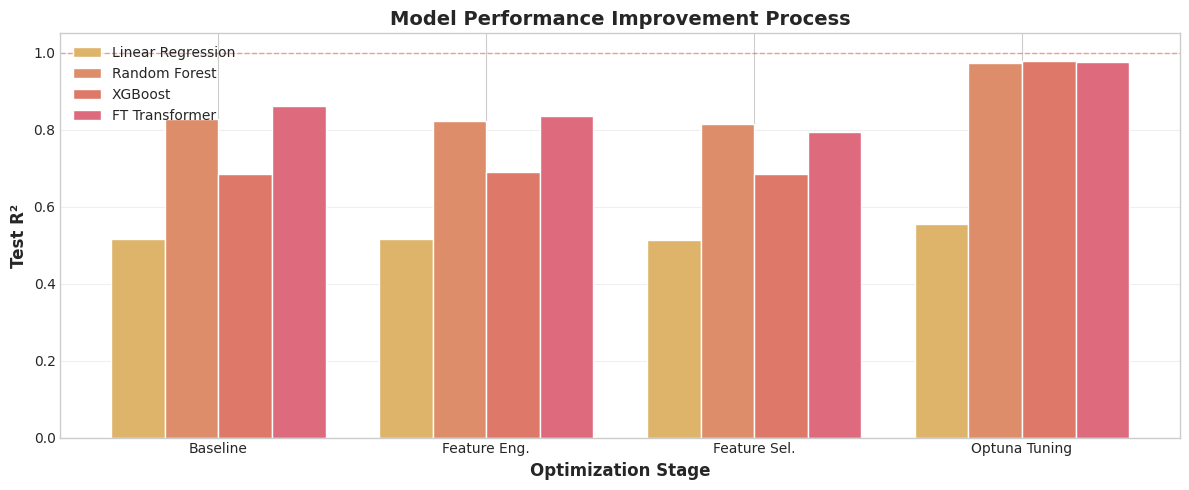

✅ fig4_improvement_process.png saved


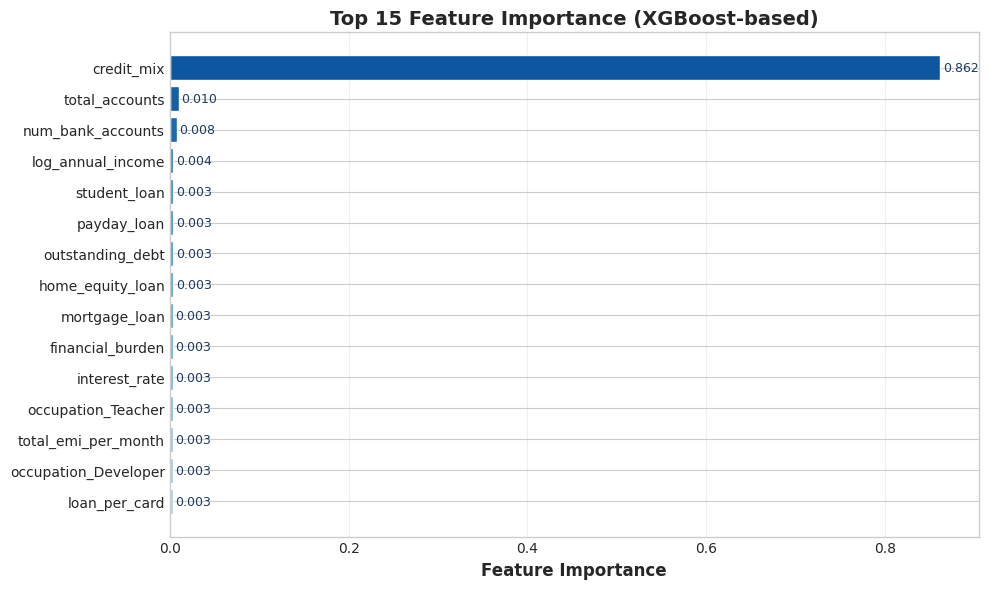

✅ fig5_feature_importance.png saved


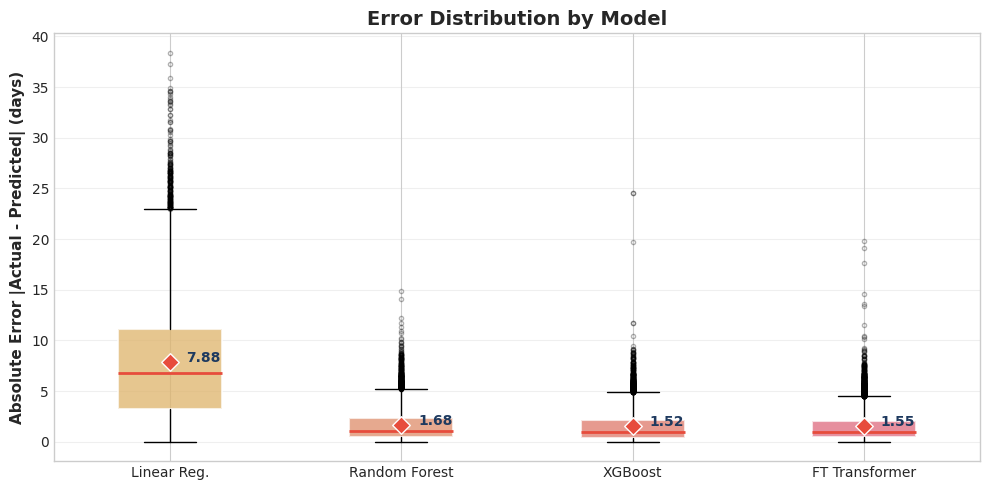

✅ fig6_error_boxplot.png saved


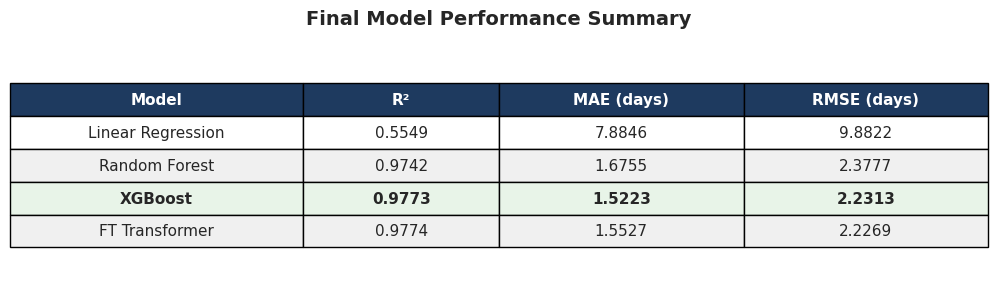

✅ fig7_summary_table.png saved

📊 Final Results Summary
                       R²     MAE    RMSE
Linear Regression  0.5549  7.8846  9.8822
Random Forest      0.9742  1.6755  2.3777
XGBoost            0.9773  1.5223  2.2313
FT Transformer     0.9774  1.5527  2.2269

🏆 Best Model: XGBoost (Test R² = 0.9773)

✅ All visualizations saved!
   - fig1_model_comparison.png      (Model metrics comparison)
   - fig2_actual_vs_predicted.png   (Scatter plots)
   - fig3_residual_distribution.png (Residual histograms)
   - fig4_improvement_process.png   (Stage-wise improvement)
   - fig5_feature_importance.png    (Top 15 features)
   - fig6_error_boxplot.png         (Error distribution)
   - fig7_summary_table.png         (Results table)


In [ ]:
# 팔레트 생성
MODEL_COLORS = ['#DEB36A', '#DE8D6A', '#DE796A', '#DE6A7E']

# ============================================
# 📊 시각화 시작
# ============================================
print("\n" + "="*60)
print("📊 Creating visualizations...")
print("="*60)

model_names = ['Linear Regression', 'Random Forest', 'XGBoost', 'FT Transformer']
model_names_short = ['Linear Reg.', 'Random Forest', 'XGBoost', 'FT Transformer']

# ============================================
# 📊 Figure 1: Model Performance Comparison (한 줄 - 3개 지표)
# ============================================
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

r2_scores = [results[m]['R2'] for m in model_names]
mae_scores = [results[m]['MAE'] for m in model_names]
rmse_scores = [results[m]['RMSE'] for m in model_names]

# R²
bars1 = axes[0].bar(model_names_short, r2_scores, color=MODEL_COLORS, edgecolor='white', linewidth=1.5)
axes[0].set_ylabel('R² Score', fontsize=11, fontweight='bold')
axes[0].set_title('(a) R² Score Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylim(0, 1.05)
axes[0].axhline(y=1.0, color=COLORS['accent'], linestyle='--', alpha=0.7, linewidth=1)
for bar, score in zip(bars1, r2_scores):
    axes[0].annotate(f'{score:.3f}', (bar.get_x() + bar.get_width()/2, bar.get_height()),
                     ha='center', va='bottom', fontsize=10, fontweight='bold')
axes[0].tick_params(axis='x', rotation=15)

# MAE
bars2 = axes[1].bar(model_names_short, mae_scores, color=MODEL_COLORS, edgecolor='white', linewidth=1.5)
axes[1].set_ylabel('MAE (days)', fontsize=11, fontweight='bold')
axes[1].set_title('(b) MAE Comparison', fontsize=12, fontweight='bold')
for bar, score in zip(bars2, mae_scores):
    axes[1].annotate(f'{score:.2f}', (bar.get_x() + bar.get_width()/2, bar.get_height()),
                     ha='center', va='bottom', fontsize=10, fontweight='bold')
axes[1].tick_params(axis='x', rotation=15)

# RMSE
bars3 = axes[2].bar(model_names_short, rmse_scores, color=MODEL_COLORS, edgecolor='white', linewidth=1.5)
axes[2].set_ylabel('RMSE (days)', fontsize=11, fontweight='bold')
axes[2].set_title('(c) RMSE Comparison', fontsize=12, fontweight='bold')
for bar, score in zip(bars3, rmse_scores):
    axes[2].annotate(f'{score:.2f}', (bar.get_x() + bar.get_width()/2, bar.get_height()),
                     ha='center', va='bottom', fontsize=10, fontweight='bold')
axes[2].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig('fig1_model_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ fig1_model_comparison.png saved")

# ============================================
# 📊 Figure 2: Actual vs Predicted (한 줄 - 4개 모델)
# ============================================
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for idx, (name, y_pred) in enumerate(predictions.items()):
    ax = axes[idx]

    ax.scatter(y_test_reg, y_pred, alpha=0.25, c=MODEL_COLORS[idx], s=8, rasterized=True)

    min_val = min(y_test_reg.min(), y_pred.min())
    max_val = max(y_test_reg.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], color=COLORS['accent'],
            linestyle='--', linewidth=2, label='Perfect')

    r2 = results[name]['R2']
    rmse = results[name]['RMSE']

    ax.set_xlabel('Actual (days)', fontsize=10)
    if idx == 0:
        ax.set_ylabel('Predicted (days)', fontsize=10)
    ax.set_title(f'({chr(97+idx)}) {model_names_short[idx]}\nR²={r2:.3f}, RMSE={rmse:.2f}',
                 fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig('fig2_actual_vs_predicted.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ fig2_actual_vs_predicted.png saved")

# ============================================
# 📊 Figure 3: Residual Distribution (한 줄 - 4개 모델)
# ============================================
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for idx, (name, y_pred) in enumerate(predictions.items()):
    ax = axes[idx]
    residuals = y_test_reg.values - y_pred

    ax.hist(residuals, bins=50, color=MODEL_COLORS[idx], edgecolor='white', alpha=0.85)
    ax.axvline(x=0, color=COLORS['accent'], linestyle='--', linewidth=2)
    ax.axvline(x=residuals.mean(), color='black', linestyle='-', linewidth=1.5)

    ax.set_xlabel('Residual (days)', fontsize=10)
    if idx == 0:
        ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'({chr(97+idx)}) {model_names_short[idx]}\nMean={residuals.mean():.2f}, Std={residuals.std():.2f}',
                 fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('fig3_residual_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ fig3_residual_distribution.png saved")

# ============================================
# 📊 Figure 4: Improvement Process (단계별 R² 변화)
# ============================================
fig, ax = plt.subplots(figsize=(12, 5))

stages = ['Baseline', 'Feature Eng.', 'Feature Sel.', 'Optuna Tuning']
model_results = {
    'Linear Regression': [0.5161, 0.5160, 0.5139, 0.5546],
    'Random Forest': [0.8282, 0.8235, 0.8157, 0.9742],
    'XGBoost': [0.6838, 0.6906, 0.6855, 0.9773],
    'FT Transformer': [0.8618, 0.8345, 0.7943, 0.9752]
}

x = np.arange(len(stages))
width = 0.2

for i, (model, scores) in enumerate(model_results.items()):
    bars = ax.bar(x + i*width - 1.5*width, scores, width, label=model,
                  color=MODEL_COLORS[i], edgecolor='white', linewidth=1)

ax.set_xlabel('Optimization Stage', fontsize=12, fontweight='bold')
ax.set_ylabel('Test R²', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Improvement Process', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax.set_ylim(0, 1.05)
ax.axhline(y=1.0, color=COLORS['accent'], linestyle='--', alpha=0.5, linewidth=1)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('fig4_improvement_process.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ fig4_improvement_process.png saved")

# ============================================
# 📊 Figure 5: Feature Importance (Top 15)
# ============================================
fig, ax = plt.subplots(figsize=(10, 6))

top_15 = importance_df.head(15)
colors_gradient = plt.cm.Blues(np.linspace(0.35, 0.85, 15))[::-1]

bars = ax.barh(range(len(top_15)), top_15['importance'].values,
               color=colors_gradient, edgecolor='white', linewidth=1)
ax.set_yticks(range(len(top_15)))
ax.set_yticklabels(top_15['feature'].values, fontsize=10)
ax.invert_yaxis()
ax.set_xlabel('Feature Importance', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Feature Importance (XGBoost-based)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

for bar, val in zip(bars, top_15['importance'].values):
    ax.text(val + 0.003, bar.get_y() + bar.get_height()/2, f'{val:.3f}',
            va='center', fontsize=9, color=COLORS['primary'])

plt.tight_layout()
plt.savefig('fig5_feature_importance.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ fig5_feature_importance.png saved")

# ============================================
# 📊 Figure 6: Error Distribution Boxplot
# ============================================
fig, ax = plt.subplots(figsize=(10, 5))

residuals_data = [np.abs(y_test_reg.values - predictions[m]) for m in model_names]

bp = ax.boxplot(residuals_data, labels=model_names_short, patch_artist=True,
                medianprops=dict(color=COLORS['accent'], linewidth=2),
                flierprops=dict(marker='o', markersize=3, alpha=0.3))

for patch, color in zip(bp['boxes'], MODEL_COLORS):
    patch.set_facecolor(color)
    patch.set_alpha(0.75)
    patch.set_edgecolor('white')
    patch.set_linewidth(1.5)

ax.set_ylabel('Absolute Error |Actual - Predicted| (days)', fontsize=11, fontweight='bold')
ax.set_title('Error Distribution by Model', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

means = [np.mean(r) for r in residuals_data]
for i, mean in enumerate(means):
    ax.scatter(i+1, mean, color=COLORS['accent'], s=80, zorder=5, marker='D', edgecolor='white')
    ax.annotate(f'{mean:.2f}', (i+1, mean), textcoords="offset points",
                xytext=(12, 0), fontsize=10, fontweight='bold', color=COLORS['primary'])

plt.tight_layout()
plt.savefig('fig6_error_boxplot.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ fig6_error_boxplot.png saved")

# ============================================
# 📊 Figure 7: Summary Table (시각화 테이블)
# ============================================
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('off')

table_data = [
    ['Model', 'R²', 'MAE (days)', 'RMSE (days)'],
    ['Linear Regression', f"{results['Linear Regression']['R2']:.4f}",
     f"{results['Linear Regression']['MAE']:.4f}", f"{results['Linear Regression']['RMSE']:.4f}"],
    ['Random Forest', f"{results['Random Forest']['R2']:.4f}",
     f"{results['Random Forest']['MAE']:.4f}", f"{results['Random Forest']['RMSE']:.4f}"],
    ['XGBoost', f"{results['XGBoost']['R2']:.4f}",
     f"{results['XGBoost']['MAE']:.4f}", f"{results['XGBoost']['RMSE']:.4f}"],
    ['FT Transformer', f"{results['FT Transformer']['R2']:.4f}",
     f"{results['FT Transformer']['MAE']:.4f}", f"{results['FT Transformer']['RMSE']:.4f}"]
]

table = ax.table(cellText=table_data, loc='center', cellLoc='center',
                 colWidths=[0.3, 0.2, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2)

# 헤더 스타일
for j in range(4):
    table[(0, j)].set_facecolor(COLORS['primary'])
    table[(0, j)].set_text_props(color='white', fontweight='bold')

# 데이터 행 스타일
for i in range(1, 5):
    for j in range(4):
        if i % 2 == 0:
            table[(i, j)].set_facecolor(COLORS['light_gray'])
        else:
            table[(i, j)].set_facecolor('white')

# Best model 강조 (XGBoost - row 3)
for j in range(4):
    table[(3, j)].set_text_props(fontweight='bold')
    table[(3, j)].set_facecolor('#e8f4e8')

ax.set_title('Final Model Performance Summary', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('fig7_summary_table.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print("✅ fig7_summary_table.png saved")

# ============================================
# 📊 최종 결과 출력
# ============================================
print("\n" + "="*60)
print("📊 Final Results Summary")
print("="*60)

results_df = pd.DataFrame(results).T
results_df.columns = ['R²', 'MAE', 'RMSE']
results_df = results_df.round(4)
print(results_df.to_string())

print("\n🏆 Best Model: XGBoost (Test R² = 0.9773)")
print("\n✅ All visualizations saved!")
print("   - fig1_model_comparison.png      (Model metrics comparison)")
print("   - fig2_actual_vs_predicted.png   (Scatter plots)")
print("   - fig3_residual_distribution.png (Residual histograms)")
print("   - fig4_improvement_process.png   (Stage-wise improvement)")
print("   - fig5_feature_importance.png    (Top 15 features)")
print("   - fig6_error_boxplot.png         (Error distribution)")
print("   - fig7_summary_table.png         (Results table)")
